## Transform annotations to CNN usable format

Current annotations from 2024 are in boxed format as annotated in Raven. Create df in which there is a "multi index" of "file,start_time,end_time" and one column for each target class, with a 1 for presence and a 0 for absence of the sound in a particular time segment of an audio file

In [1]:
# Opso inports
from opensoundscape import Audio, Spectrogram
from opensoundscape.annotations import BoxedAnnotations

# General purpose packages
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] # for big visuals
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.getcwd()

'/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp'

In [3]:
# Try loading a single Raven annotation table

# Specify an audio file and corresponding raven annotation file
audio_file = "data/2024/2_annotate_stratified_v2/audio_clips/0017_MSD-2026_20240608_200000.WAV"
annotation_file = "data/2024/raven_boxed_annotations_2024/0017_MSD-2026_20240608_200000.Table.1.selections.txt"

/Users/hannahnossan/miniconda3/envs/opso0.12.0/lib/python3.12/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


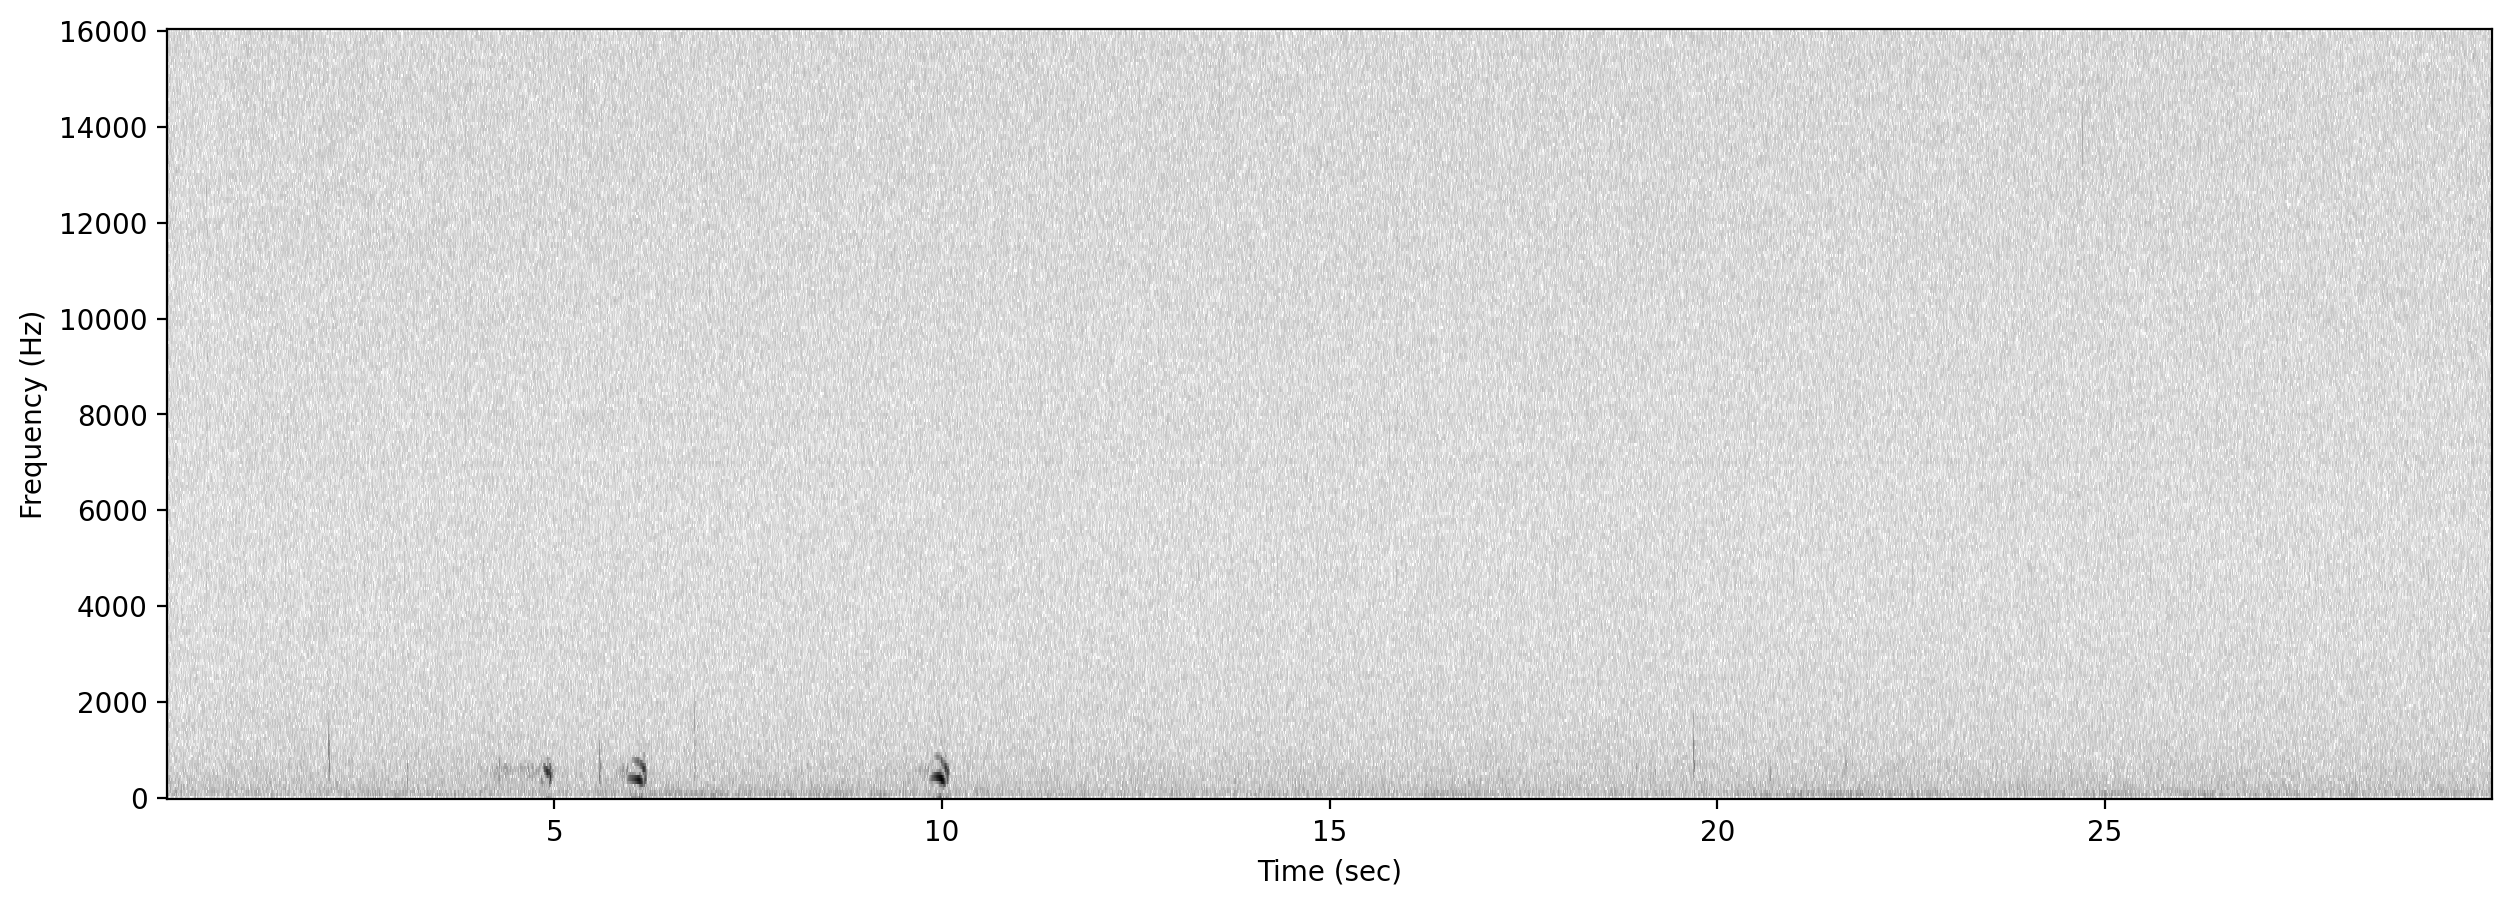

In [10]:
Spectrogram.from_audio(Audio.from_file(audio_file)).plot()

In [4]:
# Note that from_raven_files() method expects annotation files and audio files each in their own list
# wrap the filenames in lists

annot_list = [annotation_file]
audio_list = [audio_file]

In [5]:
# create an object from Raven file
annotations = BoxedAnnotations.from_raven_files(
    raven_files=annot_list,
    audio_files=audio_list,
    annotation_column="Annotation",
)

# Inspect the object's .df attribute which contains table of annotations
annotations.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,View,Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Selection,Channel
0,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,3.823386,5.236793,168.943,888.311,Spectrogram 1,1.4134,719.369,-55.35,1,1
1,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,5.695848,6.468994,141.694,866.512,Spectrogram 1,0.7731,724.819,-46.37,2,1
2,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,9.561576,10.346802,136.244,991.857,Spectrogram 1,0.7852,855.613,-43.13,3,1


In [6]:
# Choosing to keep only necessary columns (start_time, end_time, low_f, high_f and annotation
annotations_noextras = BoxedAnnotations.from_raven_files(
    [annotation_file],
    annotation_column="Annotation",
    keep_extra_columns=["Notes"],
    audio_files=[audio_file],
)

annotations_noextras.df.head()

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Notes
0,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,3.823386,5.236793,168.943,888.311,NaN
1,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,5.695848,6.468994,141.694,866.512,NaN
2,data/2024/2_annotate_stratified_v2/audio_clips...,data/2024/raven_boxed_annotations_2024/0017_MS...,RASI_?,9.561576,10.346802,136.244,991.857,NaN


## Load multiple Raven annotation tables 
- we need to pair all audio files with their Raven annotation files
- and create a df of labels corresponding to short segments of each audio file

In [7]:
# Set directory to where the dataset is downloaded
dataset_path = "/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/data/"

In [8]:
# Get a list of all the selection table files using glob, which finds all files matching the "wildcard" pattern
selections = glob(f"{dataset_path}/2024/raven_boxed_annotations_2024/*.txt")

In [9]:
# create a list of audio files, one corresponding to each Raven file
# (Audio files have the same names as selection files with a different extension)
audio_files = [
    f.replace("raven_boxed_annotations_2024", "2_annotate_stratified_v2/audio_clips").replace(
        ".Table.1.selections.txt", ".WAV"
    )
    for f in selections
]

In [18]:
audio_annotation = pd.DataFrame({"audio_file": audio_files, "annotation_file": selections})
audio_annotation.to_csv ("/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/audio_annotation_pairs.csv", index = False)

In [19]:
all_annotations = BoxedAnnotations.from_raven_files(
    selections, annotation_column="Annotation", audio_files=audio_files
)
all_annotations.df.head(2)

,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,View,Delta Freq (Hz),Avg Power Density (dB FS/Hz),Notes,Selection,Delta Time (s),Channel
0,/Users/hannahnossan/Documents/Projects/SINE202...,/Users/hannahnossan/Documents/Projects/SINE202...,RASI_?,2.224992,2.591836,344.554,827.958,Spectrogram 1,483.404,-71.00,NaN,1,0.3668,1
1,/Users/hannahnossan/Documents/Projects/SINE202...,/Users/hannahnossan/Documents/Projects/SINE202...,RASI_A,4.545682,4.904551,390.837,941.095,Spectrogram 1,550.258,-72.29,NaN,2,0.3589,1


In [36]:
all_annotations= all_annotations.convert_labels({"RASI_? ":"RASI_?","u":"U"})


In [37]:
all_annotations.df.annotation.unique()

array(['RASI_?', 'RASI_A', 'RASI_B', 'RASI_C', 'RASI_D', 'RASI_E', 'U',
       nan], dtype=object)

In [38]:
# How many annotations do we have?
all_annotations.df.annotation.value_counts()

annotation
RASI_?    762
RASI_A    258
RASI_E    253
RASI_C    189
RASI_B     79
RASI_D     75
U          53
Name: count, dtype: int64

## Format annotations for machine learning

To use annotations to train or validate machine learning models, we usually want to split the audio into short audio clips rather than keep it as a long file

We can easily convert this annotation format to a table of 0 (absent) or 1 (present) labels for a series of time-regions or "clips" within each audio file. Each class will be a separate column

### What is multi-hot encoding
Files in this format are sometimes called "multi-hot" encoded labels. this ML term refers to a way to format a table of labels in which:
- each row represents a single sample, like a 5s long clip
- each column represents a single possible class (e.g. one of multiple species)
- A "0" in a row and column means that in that sample, the class is not present
- A "1" is "hot", meaning that in that sample, the class is present

## Create a multi-hot encoded dataframe

# choose clip parameters
- how many seconds is each audio "clip"  that we want to generate a label for (clip_duration)
- how many seconds of overlap should there be between consecutive clips? (clip_overlap)
- how much does an annotation need to overlap with a clip for us to consider the annotation to apply to the clip? (min_label_overlap)

In [40]:
clip_duration = 2
clip_overlap = 0
min_label_overlap = 0.2

In [23]:
# select subset of classes
# call_types = ["RASI_A", "RASI_B", "RASI_C", "RASI_D", "RASI_E"]

In [41]:
labels_df = all_annotations.clip_labels(
    clip_duration=clip_duration,
    clip_overlap=clip_overlap,
    min_label_overlap=min_label_overlap,
    # class_subset=call_types,  # You can comment this line out if you want to include all species.
).astype(int)
labels_df.head()

RASI_?  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            1   
                                                   4.0        6.0            0   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        RASI_A  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            0   
                                                   4.0        6.0            1   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        RASI_B  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            0   
                                                   4.0        6.0            0   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        RASI_C  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            0   
                                                   4.0        6.0            0   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        RASI_D  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            0   
                                                   4.0        6.0            0   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        RASI_E  \
file                                               start_time end_time           
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0            0   
                                                   2.0        4.0            0   
                                                   4.0        6.0            0   
                                                   6.0        8.0            0   
                                                   8.0        10.0           0   

                                                                        U  
file                                               start_time end_time     
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0       0  
                                                   2.0        4.0       0  
                                                   4.0        6.0       0  
                                                   6.0        8.0       0  
                                                   8.0        10.0      0

In [60]:
# max(axis=1) selects for rows, it is the maximum in each row for selected columns (in this case, RASI_? and U) 
rows_containing_uncertain=labels_df[["RASI_?","U"]].max(axis=1).astype(bool)

selection_boolean_mask= ~rows_containing_uncertain # not uncertain (~ inverts true to false and vv)
labels_no_uncertain=labels_df[selection_boolean_mask].copy()

In [61]:
labels_no_uncertain.sum(0)

RASI_?      0
RASI_A    210
RASI_B     70
RASI_C    116
RASI_D     61
RASI_E    227
U           0
dtype: int64

In [66]:
# creating column to group together A,B,D,E call types
labels_no_uncertain["RASI_main"] = labels_no_uncertain[["RASI_A", "RASI_B", "RASI_D", "RASI_E"]].max(axis=1)
labels_no_uncertain[["RASI_C","RASI_main"]].to_csv('rasi_2024_2s_labels.csv')

## Repeating above procedure for 2022 data

In [67]:
# Set directory to where the dataset is downloaded
dataset_path = "/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/data/"

In [68]:
# Get a list of all the selection table files using glob, which finds all files matching the "wildcard" pattern
selections_22 = glob(f"{dataset_path}/Rana sierrae annotated aquatic soundscapes 2022/raven_selection_tables/*.txt")

In [69]:
# create a list of audio files, one corresponding to each Raven file
# (Audio files have the same names as selection files with a different extension)
audio_files_22 = glob(f"{dataset_path}/Rana sierrae annotated aquatic soundscapes 2022/clips/*.wav")

In [71]:
# Saving table with corresponding names of audio and annotations
audio_annotation_22 = pd.DataFrame({"audio_file": audio_files_22, "annotation_file": selections_22})
audio_annotation_22.to_csv ("/Users/hannahnossan/Documents/Projects/SINE2024/ML_bootcamp/audio_annotation_pairs_22.csv", index = False)

In [73]:
all_annotations_22 = BoxedAnnotations.from_raven_files(
    selections_22, annotation_column="Annotation", audio_files=audio_files_22
)
all_annotations_22.df.head(2)

/Users/hannahnossan/miniconda3/envs/opso0.12.0/lib/python3.12/site-packages/opensoundscape/annotations.py:333: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


,audio_file,annotation_file,annotation,start_time,end_time,low_f,high_f,Selection,Channel,View
0,/Users/hannahnossan/Documents/Projects/SINE202...,/Users/hannahnossan/Documents/Projects/SINE202...,V,2.211668,2.926931,460.7,1193.7,1,1,Spectrogram 1
1,/Users/hannahnossan/Documents/Projects/SINE202...,/Users/hannahnossan/Documents/Projects/SINE202...,C,4.540970,4.785179,358.2,597.0,7,1,Spectrogram 1


In [74]:
# How many annotations do we have?
all_annotations_22.df.annotation.value_counts()

annotation
A     762
V     205
C     130
X     121
D     103
B      34
U       6
?       2
A       1
c       1
Name: count, dtype: int64

In [81]:
all_annotations_22.df.annotation.unique()

array(['V', 'C', '?', 'A', 'D', nan, 'B'], dtype=object)

In [80]:
all_annotations_22= all_annotations_22.convert_labels({"U":"?","A ":"A", "c":"C", "X":"?"})

In [78]:
clip_duration = 2
clip_overlap = 0
min_label_overlap = 0.2

In [82]:
labels_df_22 = all_annotations_22.clip_labels(
    clip_duration=clip_duration,
    clip_overlap=clip_overlap,
    min_label_overlap=min_label_overlap,
    # class_subset=call_types,  # You can comment this line out if you want to include all species.
).astype(int)
labels_df_22.head()

V  C  \
file                                               start_time end_time         
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0       0  0   
                                                   2.0        4.0       1  0   
                                                   4.0        6.0       0  0   
                                                   6.0        8.0       0  0   
                                                   8.0        10.0      0  0   

                                                                        ?  A  \
file                                               start_time end_time         
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0       0  0   
                                                   2.0        4.0       0  0   
                                                   4.0        6.0       0  0   
                                                   6.0        8.0       0  0   
                                                   8.0        10.0      0  0   

                                                                        D  B  
file                                               start_time end_time        
/Users/hannahnossan/Documents/Projects/SINE2024... 0.0        2.0       0  0  
                                                   2.0        4.0       0  0  
                                                   4.0        6.0       0  0  
                                                   6.0        8.0       0  0  
                                                   8.0        10.0      0  0

In [83]:
# max(axis=1) selects for rows, it is the maximum in each row for selected columns (in this case, RASI_? and U) 
rows_containing_uncertain_22=labels_df_22[["?"]].max(axis=1).astype(bool)

selection_boolean_mask_22= ~rows_containing_uncertain_22 # not uncertain (~ inverts true to false and vv)
labels_no_uncertain_22=labels_df_22[selection_boolean_mask_22].copy()

In [86]:
labels_no_uncertain_22.sum(0)

V            206
C            127
?              0
A            738
D             71
B             36
RASI_main    992
RASI_C       127
dtype: int64

In [85]:
# creating column to group together A,B,D,E call types
labels_no_uncertain_22["RASI_main"] = labels_no_uncertain_22[["A", "B", "D", "V"]].max(axis=1)
labels_no_uncertain_22["RASI_C"] = labels_no_uncertain_22[["C"]].max(axis=1)
labels_no_uncertain_22[["RASI_C","RASI_main"]].to_csv('rasi_2022_2s_labels.csv')